In [1]:
import data_utils

list_ids, labels = data_utils.parse_dataset()

print('Number of training examples: ', len(list_ids))
print('Number of labels: ', len(labels))
print('Labels: ', labels)
print('Sample list ID: ', list_ids[0])

Number of training examples:  1021961
Number of labels:  7
Labels:  {'The Eiffel Tower', 'The Great Wall of China', 'airplane', 'The Mona Lisa', 'angel', 'alarm clock', 'ambulance'}
Sample list ID:  The Great Wall of China/4626156441567232.ndjson


Length of dataset:  1021961


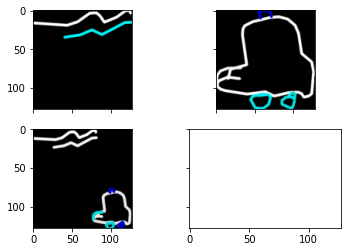

In [2]:
import datasets
import matplotlib.pyplot as plt

quick_draw_dataset = datasets.QuickDrawDataset(list_ids, labels)
individual_imgs = [1, 1008352]
img1, label1 = quick_draw_dataset[individual_imgs[0]]
img2, label2 = quick_draw_dataset[individual_imgs[1]]

# Generate a composite sketch
bounding_boxes = [[2, 3, 165, 166], [155, 156, 253, 258]]
composite_sketch, composite_labels = quick_draw_dataset.generate_composite_drawing(
    bounding_boxes, individual_imgs)
composite_img = data_utils.decode_drawing(composite_sketch)

print('Length of dataset: ', len(quick_draw_dataset))

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
axes[0,0].imshow(img1)
axes[0,1].imshow(img2)
axes[1,0].imshow(composite_img)
